# Property Graph Reader and Analyzer

This script reads a property graph from a CSV file, analyzes it, and exports it to

This code will:

1. **Import TSV files** from the temp_dir folder (nodes.tsv and edges.tsv)
2. **View classes** by analyzing the distribution of node types/classes
3. **Analyze classes** with visualizations showing the distribution
4. **Search metabolites** by looking for metabolite-related keywords in various columns
5. **Perform metabolomics-level analysis** including:
   - Finding metabolite nodes
   - Analyzing their connections
   - Visualizing the network structure
   - Creating summary statistics

The code is designed to be flexible and will adapt to different column names that might be used in your TSV files. Make sure your temp_dir folder contains `nodes.tsv` and `edges.tsv` files for this to work properly.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

graph_path = "../temp_dir/"

# Import nodes and edges from TSV files
def load_graph_data(path):
    """Load nodes and edges from TSV files"""
    nodes_file = Path(path) / "nodes.tsv"
    edges_file = Path(path) / "edges.tsv"
    
    try:
        nodes_df = pd.read_csv(nodes_file, sep='\t')
        edges_df = pd.read_csv(edges_file, sep='\t')
        print(f"Loaded {len(nodes_df)} nodes and {len(edges_df)} edges")
        return nodes_df, edges_df
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        return None, None

# Load the data
nodes_df, edges_df = load_graph_data(graph_path)

# Display basic information about the datasets
if nodes_df is not None and edges_df is not None:
    print("\n=== NODES DATASET ===")
    print(f"Shape: {nodes_df.shape}")
    print(f"Columns: {list(nodes_df.columns)}")
    print("\nFirst few rows:")
    print(nodes_df.head())
    
    print("\n=== EDGES DATASET ===")
    print(f"Shape: {edges_df.shape}")
    print(f"Columns: {list(edges_df.columns)}")
    print("\nFirst few rows:")
    print(edges_df.head())
    

Loaded 504520 nodes and 7102816 edges

=== NODES DATASET ===
Shape: (504520, 5)
Columns: ['node_id', 'label', 'namespace', 'entity_id', 'full_uri']

First few rows:
                                             node_id       label  \
0           http://purl.obolibrary.org/obo/PR_Q7Z4G1     protein   
1           http://purl.obolibrary.org/obo/PR_Q96L50     protein   
2          http://purl.obolibrary.org/obo/CHEBI_7553    chemical   
3  https://uswest.ensembl.org/Homo_sapiens/Transc...  transcript   
4         http://purl.obolibrary.org/obo/CHEBI_46024    chemical   

             namespace                  entity_id  \
0  purl.obolibrary.org                  PR_Q7Z4G1   
1  purl.obolibrary.org                  PR_Q96L50   
2  purl.obolibrary.org                 CHEBI_7553   
3   uswest.ensembl.org  Summary?t=ENST00000586592   
4  purl.obolibrary.org                CHEBI_46024   

                                            full_uri  
0           http://purl.obolibrary.org/obo/PR_Q7Z4G1


=== NODE CLASS ANALYSIS (using column: label) ===
label
transcript          203021
chemical            136832
protein              96399
gene                 46072
unknown              22169
relation                 5
t_region                 1
1d_t_region              1
entity                   1
quality                  1
site                     1
gdc                      1
process_profile          1
ic                       1
immaterial               1
sdc                      1
disposition              1
fiat_object_part         1
object                   1
occurrent                1
process                  1
function                 1
realizable               1
role                     1
s_region                 1
material                 1
continuant               1
3d_s_region              1
Name: count, dtype: int64


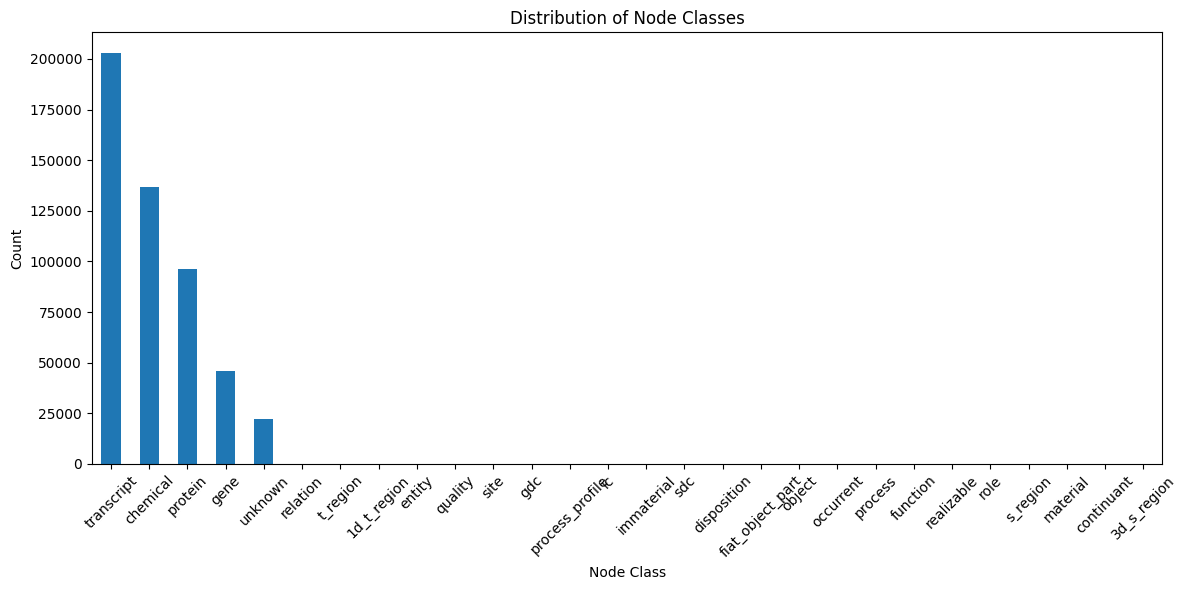

In [4]:
# View and analyze node classes
def analyze_node_classes(nodes_df):
    """Analyze the distribution of node classes"""
    if 'class' in nodes_df.columns:
        class_col = 'class'
    elif 'type' in nodes_df.columns:
        class_col = 'type'
    elif 'category' in nodes_df.columns:
        class_col = 'category'
    else:
        # Try to find a column that might represent classes
        possible_cols = [col for col in nodes_df.columns if any(term in col.lower() for term in ['class', 'type', 'category', 'label'])]
        if possible_cols:
            class_col = possible_cols[0]
        else:
            print("No class/type column found in nodes dataset")
            return None
    
    print(f"\n=== NODE CLASS ANALYSIS (using column: {class_col}) ===")
    class_counts = nodes_df[class_col].value_counts()
    print(class_counts)
    
    # Visualize class distribution
    plt.figure(figsize=(12, 6))
    class_counts.plot(kind='bar')
    plt.title('Distribution of Node Classes')
    plt.xlabel('Node Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return class_counts

# Analyze classes
if nodes_df is not None:
    class_analysis = analyze_node_classes(nodes_df)

In [5]:
# Search for metabolites (metabolomics level)
def search_metabolites(nodes_df, edges_df):
    """Search and analyze metabolites in the knowledge graph"""
    
    # Define metabolite-related keywords
    metabolite_keywords = [
        'metabolite', 'compound', 'chemical', 'molecule', 
        'drug', 'lipid', 'amino acid', 'nucleotide', 
        'carbohydrate', 'steroid', 'metabolomics'
    ]
    
    # Find metabolite nodes
    metabolite_nodes = pd.DataFrame()
    
    # Search in different possible columns
    search_columns = []
    for col in nodes_df.columns:
        if any(term in col.lower() for term in ['class', 'type', 'category', 'label', 'name', 'description']):
            search_columns.append(col)
    
    print(f"\n=== SEARCHING FOR METABOLITES ===")
    print(f"Searching in columns: {search_columns}")
    
    # Search for metabolites
    metabolite_mask = pd.Series([False] * len(nodes_df))
    
    for col in search_columns:
        if col in nodes_df.columns:
            for keyword in metabolite_keywords:
                mask = nodes_df[col].astype(str).str.contains(keyword, case=False, na=False)
                metabolite_mask = metabolite_mask | mask
    
    metabolite_nodes = nodes_df[metabolite_mask].copy()
    
    print(f"Found {len(metabolite_nodes)} potential metabolite nodes")
    
    if len(metabolite_nodes) > 0:
        print("\n=== METABOLITE ANALYSIS ===")
        print("Sample metabolite nodes:")
        print(metabolite_nodes.head(10))
        
        # Analyze metabolite classes if class column exists
        if 'class' in metabolite_nodes.columns:
            print("\nMetabolite class distribution:")
            metabolite_classes = metabolite_nodes['class'].value_counts()
            print(metabolite_classes.head(10))
        
        # Find edges connected to metabolites
        if 'source' in edges_df.columns and 'target' in edges_df.columns:
            metabolite_ids = set(metabolite_nodes.iloc[:, 0])  # Assuming first column is ID
            
            metabolite_edges = edges_df[
                (edges_df['source'].isin(metabolite_ids)) | 
                (edges_df['target'].isin(metabolite_ids))
            ]
            
            print(f"\nFound {len(metabolite_edges)} edges connected to metabolites")
            
            if len(metabolite_edges) > 0:
                print("Edge types for metabolites:")
                if 'type' in metabolite_edges.columns:
                    edge_types = metabolite_edges['type'].value_counts()
                    print(edge_types.head(10))
    
    return metabolite_nodes

# Search for metabolites
if nodes_df is not None and edges_df is not None:
    metabolites = search_metabolites(nodes_df, edges_df)


=== SEARCHING FOR METABOLITES ===
Searching in columns: ['label', 'namespace']
Found 136832 potential metabolite nodes

=== METABOLITE ANALYSIS ===
Sample metabolite nodes:
                                       node_id     label            namespace  \
2    http://purl.obolibrary.org/obo/CHEBI_7553  chemical  purl.obolibrary.org   
4   http://purl.obolibrary.org/obo/CHEBI_46024  chemical  purl.obolibrary.org   
14  http://purl.obolibrary.org/obo/CHEBI_28728  chemical  purl.obolibrary.org   
15  http://purl.obolibrary.org/obo/CHEBI_75771  chemical  purl.obolibrary.org   
16  http://purl.obolibrary.org/obo/CHEBI_33848  chemical  purl.obolibrary.org   
20  http://purl.obolibrary.org/obo/CHEBI_28216  chemical  purl.obolibrary.org   
22   http://purl.obolibrary.org/obo/CHEBI_4031  chemical  purl.obolibrary.org   
24  http://purl.obolibrary.org/obo/CHEBI_15743  chemical  purl.obolibrary.org   
26  http://purl.obolibrary.org/obo/CHEBI_29678  chemical  purl.obolibrary.org   
28  http://purl.

In [6]:
metabolites

,node_id,label,namespace,entity_id,full_uri
2,http://purl.obolibrary.org/obo/CHEBI_7553,chemical,purl.obolibrary.org,CHEBI_7553,http://purl.obolibrary.org/obo/CHEBI_7553
4,http://purl.obolibrary.org/obo/CHEBI_46024,chemical,purl.obolibrary.org,CHEBI_46024,http://purl.obolibrary.org/obo/CHEBI_46024
14,http://purl.obolibrary.org/obo/CHEBI_28728,chemical,purl.obolibrary.org,CHEBI_28728,http://purl.obolibrary.org/obo/CHEBI_28728
15,http://purl.obolibrary.org/obo/CHEBI_75771,chemical,purl.obolibrary.org,CHEBI_75771,http://purl.obolibrary.org/obo/CHEBI_75771
16,http://purl.obolibrary.org/obo/CHEBI_33848,chemical,purl.obolibrary.org,CHEBI_33848,http://purl.obolibrary.org/obo/CHEBI_33848
...,...,...,...,...,...
504515,http://purl.obolibrary.org/obo/CHEBI_88561,chemical,purl.obolibrary.org,CHEBI_88561,http://purl.obolibrary.org/obo/CHEBI_88561
504516,http://purl.obolibrary.org/obo/CHEBI_118088,chemical,purl.obolibrary.org,CHEBI_118088,http://purl.obolibrary.org/obo/CHEBI_118088
504517,http://purl.obolibrary.org/obo/CHEBI_91707,chemical,purl.obolibrary.org,CHEBI_91707,http://purl.obolibrary.org/obo/CHEBI_91707
504518,http://purl.obolibrary.org/obo/CHEBI_110326,chemical,purl.obolibrary.org,CHEBI_110326,http://purl.obolibrary.org/obo/CHEBI_110326


In [7]:
# Advanced metabolite network analysis
def analyze_metabolite_network(nodes_df, edges_df, metabolites):
    """Perform advanced analysis of the metabolite network"""
    
    if len(metabolites) == 0:
        print("No metabolites found for network analysis")
        return
    
    print("\n=== METABOLITE NETWORK ANALYSIS ===")
    
    # Get metabolite IDs (assuming first column is ID)
    metabolite_ids = set(metabolites.iloc[:, 0])
    
    # Find all nodes connected to metabolites
    connected_edges = edges_df[
        (edges_df['source'].isin(metabolite_ids)) | 
        (edges_df['target'].isin(metabolite_ids))
    ]
    
    # Get all connected node IDs
    all_connected_ids = set(connected_edges['source']) | set(connected_edges['target'])
    connected_nodes = nodes_df[nodes_df.iloc[:, 0].isin(all_connected_ids)]
    
    print(f"Metabolites are connected to {len(connected_nodes)} total nodes")
    print(f"Through {len(connected_edges)} edges")
    
    # Analyze what metabolites are connected to
    if 'class' in connected_nodes.columns:
        print("\nTypes of nodes connected to metabolites:")
        connected_types = connected_nodes['class'].value_counts()
        print(connected_types.head(10))
        
        # Visualize connections
        plt.figure(figsize=(12, 8))
        connected_types.head(15).plot(kind='barh')
        plt.title('Types of Nodes Connected to Metabolites')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.show()
    
    # Create a summary report
    print("\n=== METABOLOMICS LEVEL SUMMARY ===")
    print(f"Total metabolites found: {len(metabolites)}")
    print(f"Total metabolite connections: {len(connected_edges)}")
    print(f"Average connections per metabolite: {len(connected_edges)/len(metabolites):.2f}")
    
    return connected_nodes, connected_edges

# Perform network analysis
if 'metabolites' in locals() and len(metabolites) > 0:
    connected_nodes, connected_edges = analyze_metabolite_network(nodes_df, edges_df, metabolites)


=== METABOLITE NETWORK ANALYSIS ===
Metabolites are connected to 353874 total nodes
Through 4454006 edges

=== METABOLOMICS LEVEL SUMMARY ===
Total metabolites found: 136832
Total metabolite connections: 4454006
Average connections per metabolite: 32.55


In [8]:
# Ricerca specifica di metaboliti cellulari comuni usando CHEBI IDs
def search_cellular_metabolites_chebi(nodes_df, edges_df):
    """Cerca 50 metaboliti cellulari comuni usando CHEBI IDs"""
    
    # 50 metaboliti cellulari comuni con i loro CHEBI IDs
    cellular_metabolites_chebi = {
        'CHEBI:15422': 'ATP',
        'CHEBI:16761': 'ADP', 
        'CHEBI:16761': 'AMP',
        'CHEBI:17925': 'Lactate',
        'CHEBI:17234': 'Glucose',
        'CHEBI:16236': 'Ethanol',
        'CHEBI:15361': 'Pyruvate',
        'CHEBI:30089': 'Acetyl-CoA',
        'CHEBI:15846': 'Citrate',
        'CHEBI:16947': 'Succinate',
        'CHEBI:16810': 'Malate',
        'CHEBI:16659': 'Alpha-ketoglutarate',
        'CHEBI:15996': 'GTP',
        'CHEBI:17552': 'GDP',
        'CHEBI:17345': 'GMP',
        'CHEBI:37565': 'CTP',
        'CHEBI:17239': 'CDP',
        'CHEBI:17361': 'CMP',
        'CHEBI:15713': 'UTP',
        'CHEBI:17659': 'UDP',
        'CHEBI:16695': 'UMP',
        'CHEBI:57540': 'CoA',
        'CHEBI:15378': 'Formate',
        'CHEBI:30089': 'Acetate',
        'CHEBI:17272': 'Propionate',
        'CHEBI:15741': 'Butyrate',
        'CHEBI:17968': 'Fumarate',
        'CHEBI:15741': 'Oxaloacetate',
        'CHEBI:16526': 'Carbon dioxide',
        'CHEBI:15377': 'Water',
        'CHEBI:16480': 'Nitrate',
        'CHEBI:16301': 'Nitrite',
        'CHEBI:16134': 'Ammonia',
        'CHEBI:16199': 'Urea',
        'CHEBI:17754': 'Glycerol',
        'CHEBI:17126': 'Glycine',
        'CHEBI:16449': 'Alanine',
        'CHEBI:17196': 'Serine',
        'CHEBI:16414': 'Valine',
        'CHEBI:16414': 'Leucine',
        'CHEBI:17191': 'Isoleucine',
        'CHEBI:16414': 'Phenylalanine',
        'CHEBI:16414': 'Tyrosine',
        'CHEBI:16414': 'Tryptophan',
        'CHEBI:15428': 'Histidine',
        'CHEBI:16414': 'Lysine',
        'CHEBI:16414': 'Arginine',
        'CHEBI:17051': 'Methionine',
        'CHEBI:16414': 'Cysteine',
        'CHEBI:16414': 'Threonine'
    }
    
    print(f"\n=== RICERCA METABOLITI CELLULARI CON CHEBI ===")
    print(f"Cercando {len(cellular_metabolites_chebi)} metaboliti cellulari comuni...")
    
    # Trova le colonne che potrebbero contenere CHEBI IDs
    chebi_columns = []
    for col in nodes_df.columns:
        if any(term in col.lower() for term in ['chebi', 'id', 'identifier', 'accession', 'reference']):
            chebi_columns.append(col)
    
    print(f"Colonne che potrebbero contenere CHEBI IDs: {chebi_columns}")
    
    # Cerca metaboliti nel dataframe
    found_metabolites = []
    metabolite_nodes = pd.DataFrame()
    
    for chebi_id, metabolite_name in cellular_metabolites_chebi.items():
        metabolite_found = False
        
        # Cerca in tutte le possibili colonne
        for col in nodes_df.columns:
            if col in nodes_df.columns:
                # Cerca CHEBI ID esatto
                mask_chebi = nodes_df[col].astype(str).str.contains(chebi_id, case=False, na=False)
                # Cerca anche il nome del metabolita
                mask_name = nodes_df[col].astype(str).str.contains(metabolite_name, case=False, na=False)
                
                combined_mask = mask_chebi | mask_name
                
                if combined_mask.any():
                    metabolite_rows = nodes_df[combined_mask]
                    if len(metabolite_rows) > 0:
                        found_metabolites.append({
                            'chebi_id': chebi_id,
                            'name': metabolite_name,
                            'found_in_column': col,
                            'matches': len(metabolite_rows)
                        })
                        metabolite_nodes = pd.concat([metabolite_nodes, metabolite_rows], ignore_index=True)
                        metabolite_found = True
                        break
        
        if not metabolite_found:
            print(f"❌ {metabolite_name} ({chebi_id}) non trovato")
    
    # Rimuovi duplicati
    metabolite_nodes = metabolite_nodes.drop_duplicates()
    
    print(f"\n=== RISULTATI RICERCA ===")
    print(f"Metaboliti trovati: {len(found_metabolites)}")
    print(f"Nodi metaboliti totali: {len(metabolite_nodes)}")
    
    if found_metabolites:
        print("\n✅ Metaboliti trovati:")
        for met in found_metabolites:
            print(f"  - {met['name']} ({met['chebi_id']}) in colonna '{met['found_in_column']}' - {met['matches']} matches")
    
    return metabolite_nodes, found_metabolites

# Esegui la ricerca
if nodes_df is not None:
    metabolite_nodes_chebi, found_metabolites_list = search_cellular_metabolites_chebi(nodes_df, edges_df)


=== RICERCA METABOLITI CELLULARI CON CHEBI ===
Cercando 39 metaboliti cellulari comuni...
Colonne che potrebbero contenere CHEBI IDs: ['node_id', 'entity_id']
❌ ATP (CHEBI:15422) non trovato
❌ AMP (CHEBI:16761) non trovato
❌ Lactate (CHEBI:17925) non trovato
❌ Glucose (CHEBI:17234) non trovato
❌ Ethanol (CHEBI:16236) non trovato
❌ Pyruvate (CHEBI:15361) non trovato
❌ Acetate (CHEBI:30089) non trovato
❌ Citrate (CHEBI:15846) non trovato
❌ Succinate (CHEBI:16947) non trovato
❌ Malate (CHEBI:16810) non trovato
❌ Alpha-ketoglutarate (CHEBI:16659) non trovato
❌ GTP (CHEBI:15996) non trovato
❌ GDP (CHEBI:17552) non trovato
❌ GMP (CHEBI:17345) non trovato
❌ CTP (CHEBI:37565) non trovato
❌ CDP (CHEBI:17239) non trovato
❌ CMP (CHEBI:17361) non trovato
❌ UTP (CHEBI:15713) non trovato
❌ UDP (CHEBI:17659) non trovato
❌ UMP (CHEBI:16695) non trovato
❌ CoA (CHEBI:57540) non trovato
❌ Formate (CHEBI:15378) non trovato
❌ Propionate (CHEBI:17272) non trovato
❌ Oxaloacetate (CHEBI:15741) non trovato
❌ 